In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor

from pca_utils import (rfiw_phantom, mp_distribution)

First let analyse the PCA information of the fiber immersed in water phantom. This numerical phantom was mathematicaly derived for simple evaluation of diffusion weighted techniques. Although the phantom is only based in one uniform fiber boundle immersed in water, it takes into account fiber heteregoneity by seperately modeling restricted and hindered diffusion components. The phantom also includes free water partial volume effects of voxels located in the boundary between fiber and water.

To see how PCA preserves multi-shell information, we artificially generate the data of this phantom based on b-value multi-shell data. The acquisition parameters considered consited on 6 b-values = 0, 8 uniform samples gradient directions for b-value 300 s.mm-2, 30 directions for b-value 1000 s.mm-2, and 60 directions for b-value 2000 s.mm-2.

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

With the acquisition parameters defined and saved in the gradient table gtab, the phanton data is generated using function rfiw_phantom. Artificial rician noise is added with an nominal SNR of 15 (this snr is defined relative to the water component).

In [7]:
snr = 15
DWI = rfiw_phantom(gtab, snr=snr, noise_type='gaussian')

So let analyse how many principal components are relevant for this phantom. For this we compute the eigenvalues of the convariance signal relative to a voxel corresponding to a voxel containing fiber. 

In [8]:
psize = 2
m = (2*psize + 1) ** 3
n = DWI.shape[3]
k = j = i = 5
X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
        k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
print(L)

[  4.37377677e-01   7.71175704e-01   9.65262620e-01   1.04986287e+00
   1.22251378e+00   1.68628226e+00   1.84732536e+00   2.04360763e+00
   2.34411402e+00   2.64976561e+00   3.11259586e+00   3.14289570e+00
   3.47570582e+00   3.63583827e+00   3.87293942e+00   4.43052535e+00
   4.76275898e+00   5.09202421e+00   5.55267037e+00   5.94566718e+00
   6.52983955e+00   7.80964679e+00   8.07945298e+00   8.45831669e+00
   8.91140148e+00   9.57196849e+00   9.60022225e+00   1.04737312e+01
   1.11440578e+01   1.18130716e+01   1.23302391e+01   1.26685243e+01
   1.35845974e+01   1.41625513e+01   1.55252521e+01   1.61342766e+01
   1.68100941e+01   1.74088686e+01   1.82674532e+01   1.87105729e+01
   1.91891844e+01   2.00187522e+01   2.14447896e+01   2.19197732e+01
   2.22746702e+01   2.34630095e+01   2.41726081e+01   2.56063049e+01
   2.60155172e+01   2.71212855e+01   2.80655391e+01   2.90623642e+01
   2.97637283e+01   3.11357377e+01   3.23651315e+01   3.39761704e+01
   3.53817293e+01   3.61887291e+01

Only one eigenvalue has an intensity one order of magnitude larger that the others. This tell us that the signal of the selected phantom voxels can be reconstructed based only in one principal component. This make sense since the parameters of phantom were assumed to be uniform. All other eigenvalues are related to data noise. According to the Marchenko–Pastur law the eigenvalues related to noise signals are described by the Marchenko–Pastur distribution. To confirm that apart from the higher eigenvalue all others are related to noise, below we mark all eigenvalues related to the theorically marchenko-pastur distribution.

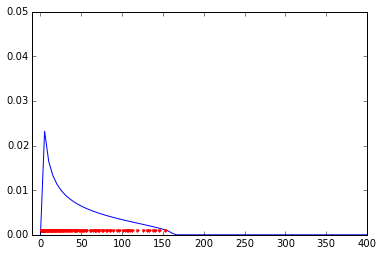

In [9]:
sigma = 100.0/snr
sig2 = sigma ** 2
y = n*1.0/m
x = np.linspace(0, 500, num=100)
p = mp_distribution(x, sig2, y)
plt.plot(x, p, 'b', L, 0.001*np.ones(L.shape), '.r')
plt.axis([-10, 400, 0, 0.05])
plt.show()

As illustrated on the above figure all lower eigenvalues range on the non-zero regime of the theoritically MP distribution.

Now I will analyse if assuming the MP distribution one can estimate the noise variance from data. For this lets define the sum of MP distribution sampled given the data's eigenvalue as function of its variance and plot this given an arbituary range of unknow variances. 

1.11950804545


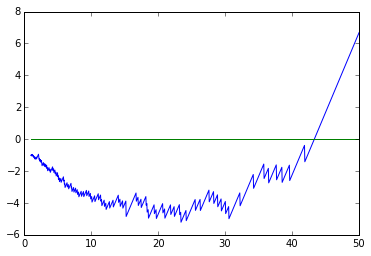

In [10]:
#rmp = lambda v: np.sum(mp_distribution(L, v, y))

# sum of MP distribution samples is not working (I tried also likelihood)
# and momentum fit (mean)
def mp_var_likelihood(x, var, y):
    xpos = var*(1+np.sqrt(y))**2
    #p = mp_distribution(x, var, y)
    return var - np.mean(x[x<xpos])
print mp_var_likelihood(L, sig2, y)

var_samples = np.linspace(1, 50, num=1000)
rmp_samples = np.empty(var_samples.shape)

for i in range(var_samples.size):
    rmp_samples[i] = mp_var_likelihood(L, var_samples[i], y)
plt.plot(var_samples, rmp_samples, var_samples, np.zeros(var_samples.shape))
plt.show()

None of the strategies was able to correctly predict the right value of sigma

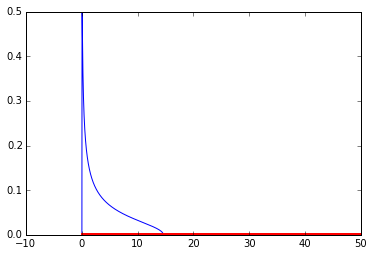

3.9995917142


In [11]:
# This is just to check that mean of MP distribution is
# sigma 2
var = 4
y = n*1.0/m
smax = 50
snum = 10000
x = np.linspace(0, smax, num=snum)
p = mp_distribution(x, var, y)
plt.plot(x, p, 'b', x, 0.001*np.ones(x.shape), '.r')
plt.axis([-10, 50, 0, 0.5])
plt.show()

print(np.sum(x * p) * smax/snum)

In [14]:
a = mp_var_likelihood(L, sigma ** 2, 103.0/125)

In [15]:
a

18.446768197113073

In [7]:
sig2

44.44444444444445

In [41]:
a/(2*np.pi*y)

5.0341721064544016

In [42]:
sigma = 100.0/snr

In [60]:
sigma ** 2

11.111111111111112